## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
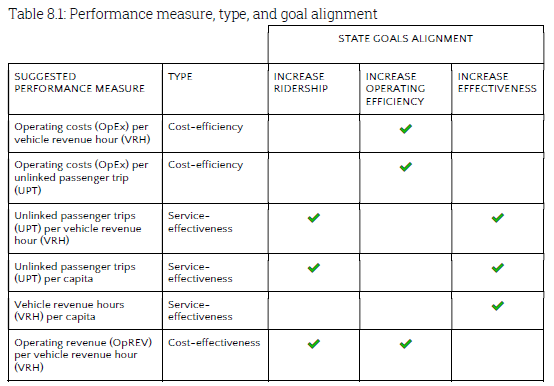

In [1]:
import pandas as pd
import numpy as np
from new_transit_metrics_utils import GCS_FILE_PATH, sum_by_group, make_long

In [2]:
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

In [20]:
df_agg = df.groupby(["agency_name","mode"]).agg(
    {"upt":"sum",
    "vrh":"sum",
    "vrm":"sum",
    "opexp_total":"sum"}
).reset_index()

In [21]:
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
    }

for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (
        df_agg[num] / df_agg[dem]
    ).round(2)

In [22]:
df_agg.head()

,agency_name,mode,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
0,Access Services (AS),Demand Response,16695038,9426628,159008226,833736052,88.44,5.24,1.77,0.10,49.94
1,Access Services (AS),Demand Response Taxi,4405674,1647003,36337091,158530393,96.25,4.36,2.67,0.12,35.98
2,Alameda-Contra Costa Transit District,Bus,216639730,10439319,106099533,2457288244,235.39,23.16,20.75,2.04,11.34
3,Alameda-Contra Costa Transit District,Bus Rapid Transit,10012230,229273,1981875,57224517,249.59,28.87,43.67,5.05,5.72
4,Alameda-Contra Costa Transit District,Commuter Bus,8398451,363100,5777682,116802450,321.68,20.22,23.13,1.45,13.91


# Dealing with NaN and inf values
Some of the metric calculation results in either inf or NaN values due to divide-by-zero scenarios. These values break the standard devatition calculation.

We will analyze the differences in standard deviation by filtering the data by these scenarios
1. remove rows with zeros
2. 
    1. upt_per_vrh/vrm NaN (0/0) values replaced with zero. Zero riders per revenue mile/hours still make sense. buses can still run and pick up zero passengers. highlights service ineffencies 
    2. opex_per_upt/vrm/vrh inf (#/0) values replaced with its opexp value. operating cost still exist even if nobody rides the bus. highlights cost inefficienies 
    3. opex_per_upt/vrm/vrh NaN (0/0) values replaced with zeros. not running the bus results in not picking up passengers and  zero operating cost.

In [28]:
# any rows with zero upt/vrh/vrm/opex?
no_zero_rows = df_agg[
    (df_agg["upt"] != 0) 
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]


In [25]:
replaced_values = df_agg.fillna(0)

# applying logic to alternate dataframe
col_list =[
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt"
]

for i in col_list:
    replaced_values[i] = replaced_values.apply(
        lambda row: row["opexp_total"] if row[i] == np.inf 
        else row[i], axis=1
    )

In [30]:
display(
    no_zero_rows.describe(),
    replaced_values.describe()
)

,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,3.520000e+02,3.520000e+02,3.520000e+02,3.520000e+02,352.000000,352.000000,352.000000,352.000000,352.000000
mean,1.580524e+07,6.900773e+05,1.042394e+07,1.320685e+08,152.105455,12.022585,10.053494,0.817472,28.689886
std,8.397362e+07,2.525418e+06,3.633696e+07,5.307031e+08,211.948732,21.986489,14.329247,1.609922,23.689859
min,3.646000e+03,1.125000e+03,1.375200e+04,5.805500e+04,21.930000,0.520000,0.620000,0.050000,1.860000
25%,1.195410e+05,3.349275e+04,3.730685e+05,3.169014e+06,83.977500,6.037500,2.590000,0.190000,10.157500
50%,4.433130e+05,9.376350e+04,1.420240e+06,1.013965e+07,114.285000,8.675000,5.355000,0.375000,18.705000
75%,3.039104e+06,3.634652e+05,5.522744e+06,4.987880e+07,149.925000,11.962500,11.212500,0.782500,43.847500
max,1.311211e+09,3.761806e+07,4.351329e+08,7.272747e+09,2740.980000,327.640000,122.010000,18.510000,119.070000


,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,361.000000,361.000000,3.610000e+02
mean,1.541120e+07,6.728731e+05,1.016406e+07,1.287844e+08,8.633119e+03,8.496529e+03,9.802853,0.797091,8.512781e+03
std,8.295402e+07,2.495977e+06,3.591677e+07,5.244308e+08,1.291407e+05,1.291496e+05,14.235798,1.594786,1.291485e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.109580e+05,3.017600e+04,3.300900e+05,2.926879e+06,8.318000e+01,5.970000e+00,2.490000,0.180000,1.010000e+01
50%,4.203820e+05,8.871000e+04,1.357521e+06,9.127496e+06,1.145000e+02,8.690000e+00,5.240000,0.370000,1.880000e+01
75%,2.999062e+06,3.533270e+05,5.283896e+06,4.424504e+07,1.514100e+02,1.212000e+01,11.060000,0.770000,4.502000e+01
max,1.311211e+09,3.761806e+07,4.351329e+08,7.272747e+09,2.396004e+06,2.396004e+06,122.010000,18.510000,2.396004e+06


In [31]:
# who are are bottom 5% in each metrics
bottom_metrics = {
    "bottom_opex_vrh":"opex_per_vrh",
    "bottom_opex_vrm":"opex_per_vrm",
    "bottom_opex_upt":"opex_per_upt",
    "bottom_upt_vrh":"upt_per_vrh",
    "bottom_upt_vrm":"upt_per_vrm"
}
bottom_5 = {}
for k,v in bottom_metrics.items():
    bottom_5[k] = no_zero_rows[no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)]

In [63]:
for k in bottom_5:
    print(f"\n Datset: {k}"),
    display(v[["agency_name","mode",bottom_metrics[k]]].sort_values(by=bottom_metrics[k]))


 Datset: bottom_opex_vrh


,agency_name,mode,opex_per_vrh
289,San Diego Association of Governments (SANDAG) ...,Vanpool,21.93
243,Los Angeles County Metropolitan Transportation...,Vanpool,23.20
301,San Joaquin Council (SJCOG),Vanpool,25.23
248,Metropolitan Transportation Commission (MTC) -...,Vanpool,25.88
328,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,26.15
288,San Bernardino County Transportation Authority...,Vanpool,30.96
352,Victor Valley Transit Authority (VVTA),Vanpool,33.79
279,Riverside County Transportation Commission (RCTC),Vanpool,34.09
115,City of Malibu - Community Services Department,Demand Response Taxi,42.60
194,County of Placer (PCT/TART) - Department of Pu...,Vanpool,56.91



 Datset: bottom_opex_vrm


,agency_name,mode,opex_per_vrm
289,San Diego Association of Governments (SANDAG) ...,Vanpool,0.52
328,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,0.54
248,Metropolitan Transportation Commission (MTC) -...,Vanpool,0.56
243,Los Angeles County Metropolitan Transportation...,Vanpool,0.58
301,San Joaquin Council (SJCOG),Vanpool,0.59
352,Victor Valley Transit Authority (VVTA),Vanpool,0.69
288,San Bernardino County Transportation Authority...,Vanpool,0.77
279,Riverside County Transportation Commission (RCTC),Vanpool,0.86
194,County of Placer (PCT/TART) - Department of Pu...,Vanpool,1.29
337,SunLine Transit Agency,Vanpool,1.33



 Datset: bottom_opex_upt


,agency_name,mode,opex_per_upt
289,San Diego Association of Governments (SANDAG) ...,Vanpool,5.21
243,Los Angeles County Metropolitan Transportation...,Vanpool,5.75
248,Metropolitan Transportation Commission (MTC) -...,Vanpool,6.12
301,San Joaquin Council (SJCOG),Vanpool,6.14
352,Victor Valley Transit Authority (VVTA),Vanpool,6.90
328,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,7.40
288,San Bernardino County Transportation Authority...,Vanpool,8.07
279,Riverside County Transportation Commission (RCTC),Vanpool,8.18
194,County of Placer (PCT/TART) - Department of Pu...,Vanpool,13.13
337,SunLine Transit Agency,Vanpool,16.24



 Datset: bottom_upt_vrh


,agency_name,mode,upt_per_vrh
76,City of Escalon - Transit Services,Bus,1.11
357,Yolo County Transportation District (YCTD),Demand Response,1.38
195,County of Sacramento Municipal Services Agency...,Bus,1.42
315,Santa Clara Valley Transportation Authority (VTA),Demand Response,1.44
213,"Golden Gate Bridge, Highway and Transportation...",Demand Response,1.62
258,North County Transit District (NCTD),Demand Response,1.73
0,Access Services (AS),Demand Response,1.77
216,Imperial County Transportation Commission (ICTC),Demand Response,1.80
283,Riverside Transit Agency (RTA),Demand Response Taxi,1.81
115,City of Malibu - Community Services Department,Demand Response Taxi,1.84



 Datset: bottom_upt_vrm


,agency_name,mode,upt_per_vrm
76,City of Escalon - Transit Services,Bus,0.05
195,County of Sacramento Municipal Services Agency...,Bus,0.05
328,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,0.07
283,Riverside Transit Agency (RTA),Demand Response Taxi,0.07
357,Yolo County Transportation District (YCTD),Demand Response,0.08
337,SunLine Transit Agency,Vanpool,0.08
184,City of Visalia (VT) - Transportation,Commuter Bus,0.08
216,Imperial County Transportation Commission (ICTC),Demand Response,0.08
213,"Golden Gate Bridge, Highway and Transportation...",Demand Response,0.09
244,Madera County - Public Works Department,Commuter Bus,0.09
